In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.tensorboard import SummaryWriter

In [2]:
configs = {
    'train_start_date': '2014-05-01 00:00:00',
    'valid_start_date': '2014-09-01 00:00:00',
    'test_start_date': '2014-09-02 00:00:00',
    
    'window_size': 7*24,
    'target_len': 1,
    
    'batch_size': 16,
    'epochs': 300,
#     'epochs': 5,  # for test
    'learning_rate': 1e-3,
    'weight_decay': 1e-6,
    'embedding_out_dim': 10,
    'es_patience': 10,
}

time_now = (datetime.datetime.now()+datetime.timedelta(hours=9)).strftime("%Y-%m-%d %H:%M:%S")
configs['time_now'] = time_now

In [3]:
data_origin = pd.read_csv('../data/data.csv')

In [4]:
data = data_origin.copy()

unique_building_index = data.shape[0]
configs['unique_building_index'] = unique_building_index

In [5]:
def target_idx(data, configs):
    train_start_index = data.columns.tolist().index(configs['train_start_date']) + configs['window_size']
    valid_start_index = data.columns.tolist().index(configs['valid_start_date'])
    test_start_index = data.columns.tolist().index(configs['test_start_date'])
    return train_start_index, valid_start_index, test_start_index

train_start_index, valid_start_index, test_start_index = target_idx(data, configs)

configs['train_start_index'] = train_start_index
configs['valid_start_index'] = valid_start_index
configs['test_start_index'] = test_start_index

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, tvt, configs):
        self.data = data
        self.tvt = tvt
        self.configs = configs
        
        assert self.tvt in ('train', 'valid', 'test')
        self.building_idx_list = list(range(configs['unique_building_index']))
        
        if self.tvt == 'train':
            self.start_index = self.configs['train_start_index']
            self.end_index = self.configs['valid_start_index']
        elif self.tvt == 'valid':
            self.start_index = self.configs['valid_start_index']
            self.end_index = self.configs['test_start_index']
        elif self.tvt == 'test':
            self.start_index = self.configs['test_start_index']
            self.end_index = self.data.shape[1]
        self.seq_len = self.end_index - self.start_index
            
        self.data_splited = data.iloc[:, self.start_index-configs['window_size']:self.end_index].reset_index(drop=True)
        
    def __len__(self):
        return self.seq_len * len(self.building_idx_list)
    
    def __getitem__(self, idx):
        building_idx = idx%self.configs['unique_building_index']
        seq_idx = idx//self.configs['unique_building_index']
        
        time_series = self.data_splited.iloc[building_idx, seq_idx:seq_idx+configs['window_size']]
        time_series = np.array(time_series).reshape(-1)
        
        target = self.data_splited.iloc[building_idx, seq_idx+configs['window_size']]
        
        building_idx = torch.tensor(building_idx).type(torch.long)
        time_series = torch.tensor(time_series).type(torch.float)
        target = torch.tensor(target).type(torch.float)
        
        return (building_idx, time_series), target

In [7]:
train_ds = TimeSeriesDataset(data, 'train', configs)
valid_ds = TimeSeriesDataset(data, 'valid', configs)
test_ds = TimeSeriesDataset(data, 'test', configs)

train_dl = DataLoader(train_ds, batch_size=configs['batch_size'], shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=configs['unique_building_index'])
test_dl = DataLoader(test_ds, batch_size=configs['unique_building_index'])

In [8]:
class NNModel(nn.Module):
    def __init__(self, configs):
        super(NNModel, self).__init__()
        self.configs = configs
        
        self.embedding = nn.Embedding(configs['unique_building_index'], configs['embedding_out_dim'])
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(configs['embedding_out_dim']+configs['window_size'], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, configs['target_len']),
        )
        
    def forward(self, building_idx, time_series):
        building_idx_embedding = self.embedding(building_idx)
        concat = torch.cat((building_idx_embedding, time_series), dim=1)
        concat = concat
        outputs = self.linear_relu_stack(concat)
        return outputs
        
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}\n')

model = NNModel(configs).to(device)
print(model)

Using device cuda

NNModel(
  (embedding): Embedding(50, 10)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=178, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [9]:
loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=configs['learning_rate'], weight_decay=configs['weight_decay'])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=configs['learning_rate']/20)
# T_max: 최대값에서 최소값으로 가는데 몇 iter, eta_min: 최소값

def MAPE(y, pred):
    return sum(abs(y-pred)/(y+1))

In [10]:
writer = SummaryWriter(f'../logs/tensorboard/mf_{configs["time_now"]}')

(building_idx, time_series), _ = iter(train_dl).next()
writer.add_graph(model, (building_idx.to(device), time_series.to(device)))
writer.close()

In [11]:
def train_one_epoch(train_dl, model, loss_fn, optimizer):
    
    n_total = len(train_dl.dataset)
    train_loss = 0
    train_mape = 0
    
    for batch, (X, y) in enumerate(train_dl):
        building_idx, time_series = X
        building_idx, time_series = building_idx.to(device), time_series.to(device)
        y = y.to(device)
        pred = model(building_idx, time_series).reshape(-1)
        loss = loss_fn(pred, y)
        train_loss += loss.item()/n_total
        mape = MAPE(y, pred)
        train_mape += mape/n_total
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % (((n_total//configs['batch_size'])+1)//5) == (((n_total//configs['batch_size'])+1)//5)-1:
            current = batch*len(y)
            print(f"loss: {loss.item():>14f}  [{current:>6d}/{n_total:>6d}]")
            
    return np.sqrt(train_loss), train_mape

In [12]:
def evaluate(dl, model, loss_fn, return_prediction=False):

    n_total = len(dl.dataset)

    if return_prediction:
        total_pred = []
    total_loss = 0
    total_mape = 0

    model.eval()
    with torch.no_grad():
        for batch, (X, target) in enumerate(dl):
            if batch == 0:
                building_idx, time_series = X
                building_idx, time_series = \
                    building_idx.to(device), time_series.to(device)
            target = target.to(device)
            
            pred = model(building_idx, time_series)
            if return_prediction:
                total_pred.append(pred.reshape(-1).cpu().tolist())

            loss = loss_fn(pred.reshape(-1), target)
            mape = MAPE(target, pred.reshape(-1))
            total_loss += loss.item()/n_total
            total_mape += mape/n_total

            next_time_series = torch.zeros_like(time_series)
            for i, (t, p) in enumerate(zip(time_series, pred)):
                next_t = torch.cat((t[1:], p), dim=0)
                next_time_series[i] = next_t
            time_series = next_time_series
            
    if return_prediction:
        return np.sqrt(total_loss), total_mape, np.transpose(np.array(total_pred))
    else:
        return np.sqrt(total_loss), total_mape

In [13]:
best_valid_rmse = np.inf
early_stop = 0
for epoch in range(configs['epochs']):
    lr_now = optimizer.param_groups[0]['lr']
    print(f'\nEpoch {epoch+1}\nLearning Rate {lr_now}\n----------------------------------------')
    train_rmse, train_mape = train_one_epoch(train_dl, model, loss_fn, optimizer)
    lr_scheduler.step()
    valid_rmse, valid_mape = evaluate(valid_dl, model, loss_fn)
            
    print(f'\nTrain RMSE: {train_rmse:>8f}, Train MAPE: {train_mape:>8f}')
    print(f'Valid RMSE: {valid_rmse:>8f}, Valid MAPE: {valid_mape:>8f}')
    
    writer.add_scalars('LR', {'learning_rate': lr_now}, epoch)
    writer.add_scalars('RMSE', {'train_rmse': train_rmse, 'valid_rmse': valid_rmse}, epoch)
    writer.add_scalars('MAPE', {'train_mape': train_mape, 'valid_mape': valid_mape}, epoch)
    
    if valid_rmse < best_valid_rmse:
        print(f'\nBreak the best valid rmse\n\t{best_valid_rmse:>8f} -> {valid_rmse:>8f}')
        best_train_rmse = train_rmse
        best_train_mape = train_mape
        best_valid_rmse = valid_rmse
        best_valid_mape = valid_mape
        torch.save(model.state_dict(), '../model/mf_model.pth')
        early_stop = 0
    else:
        early_stop += 1
    if early_stop >= configs['es_patience']:
        break
writer.close()
        
print('\nBest Model')
print(f'\tTrain RMSE: {best_train_rmse:>10f}, Train MAPE: {best_train_mape:>8f}')
print(f'\tValid RMSE: {best_valid_rmse:>10f}, Valid MAPE: {best_valid_mape:>8f}')


Epoch 1
Learning Rate 0.001
----------------------------------------
loss:    9371.955078  [ 27824/139200]
loss:    7720.344727  [ 55664/139200]
loss:   98080.820312  [ 83504/139200]
loss:   11772.648438  [111344/139200]
loss:  229858.203125  [139184/139200]

Train RMSE: 110.048649, Train MAPE: 0.166028
Valid RMSE: 133.083512, Valid MAPE: 0.159675

Break the best valid rmse
	     inf -> 133.083512

Epoch 2
Learning Rate 0.000976751845240198
----------------------------------------
loss:   54160.429688  [ 27824/139200]
loss:    5654.580078  [ 55664/139200]
loss:   18706.515625  [ 83504/139200]
loss:   16225.283203  [111344/139200]
loss:   71666.296875  [139184/139200]

Train RMSE: 86.568988, Train MAPE: 0.134430
Valid RMSE: 118.074416, Valid MAPE: 0.156996

Break the best valid rmse
	133.083512 -> 118.074416

Epoch 3
Learning Rate 0.0009092830723281001
----------------------------------------
loss:   63890.101562  [ 27824/139200]
loss:   14254.422852  [ 55664/139200]
loss:    8254.0742

In [14]:
del model

best_model = NNModel(configs).to(device)
best_model.load_state_dict(torch.load("../model/mf_model.pth"))

<All keys matched successfully>

In [15]:
test_rmse, test_mape, test_pred = evaluate(test_dl, best_model, loss_fn, return_prediction=True)

print(f'Test RMSE: {test_rmse:>8f}, Test MAPE: {test_mape:>8f}')

Test RMSE: 107.514890, Test MAPE: 0.188915


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


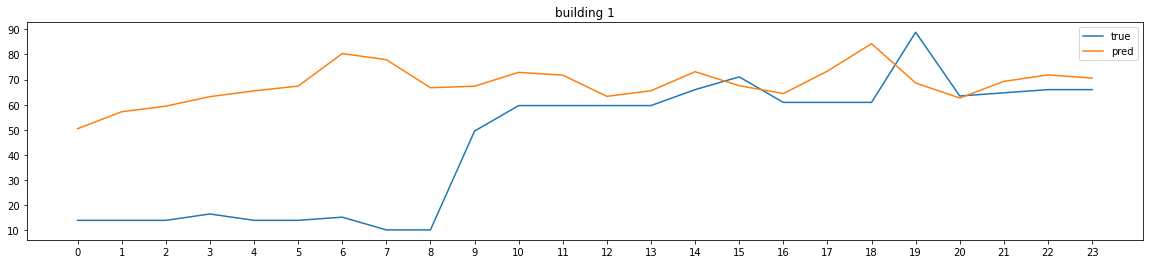

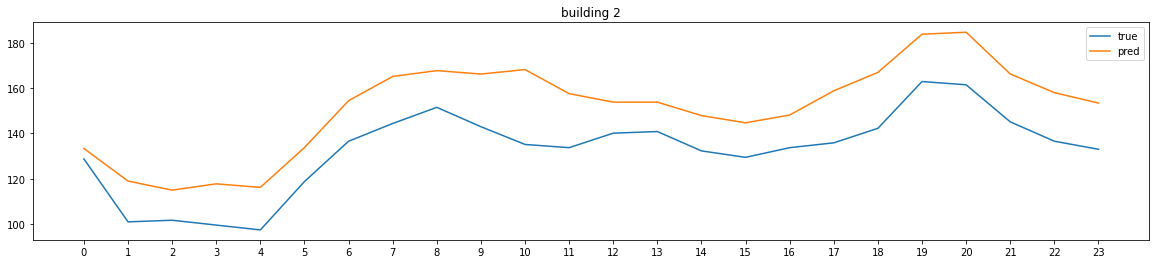

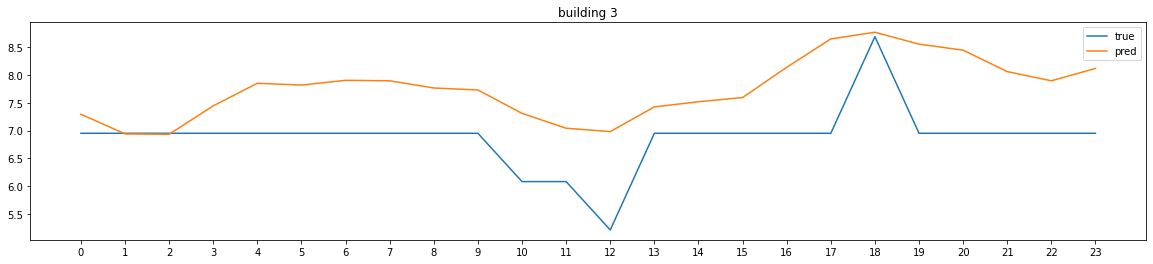

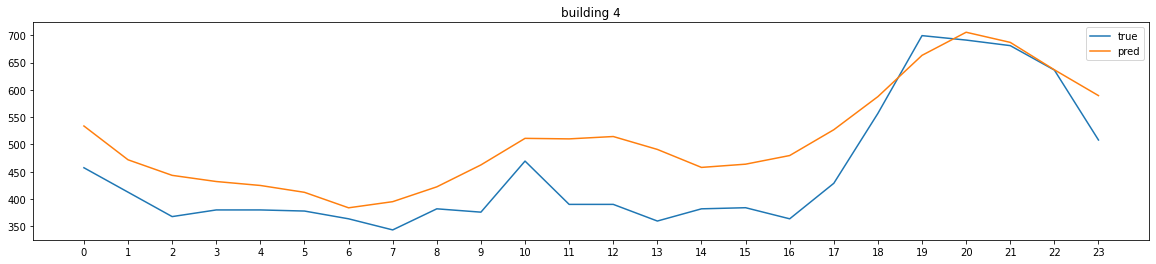

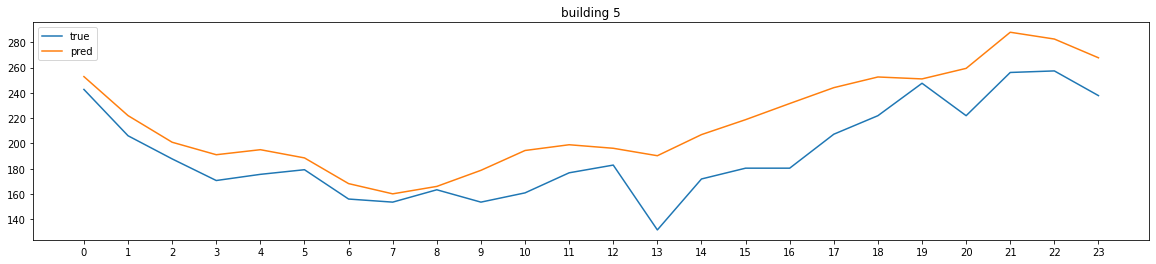

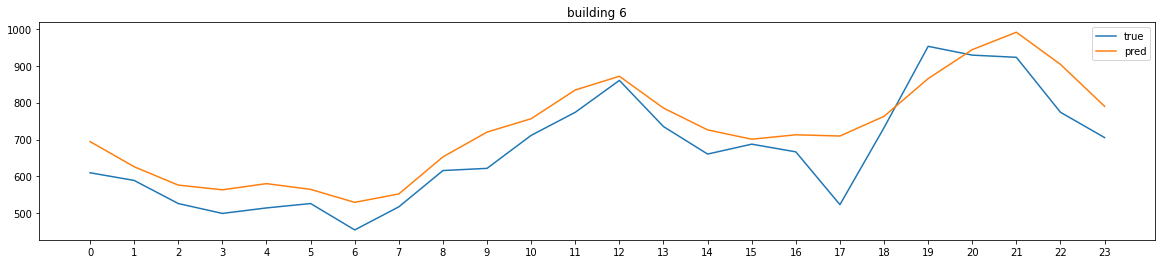

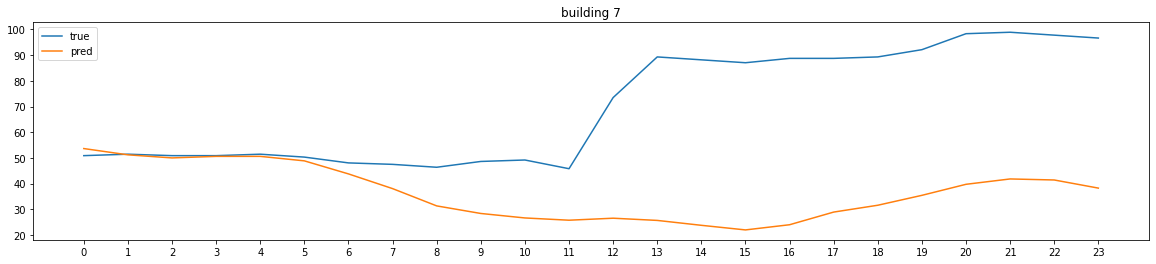

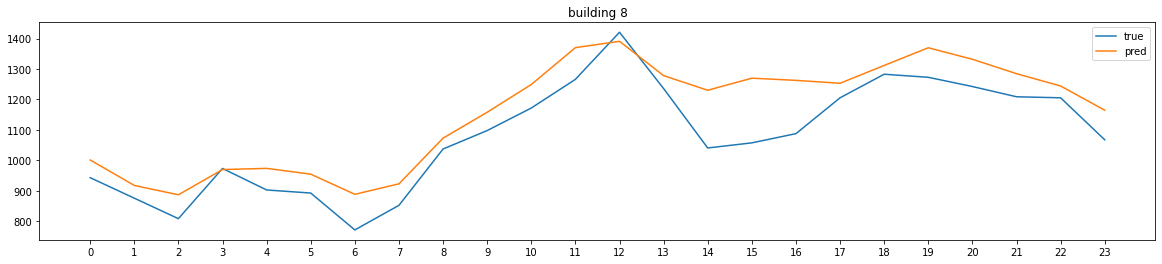

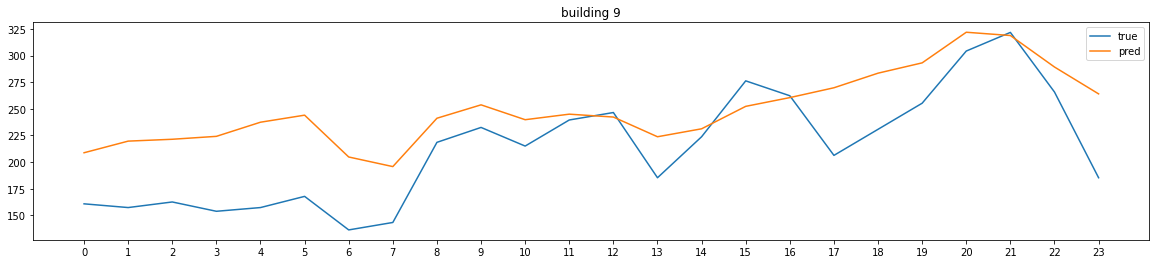

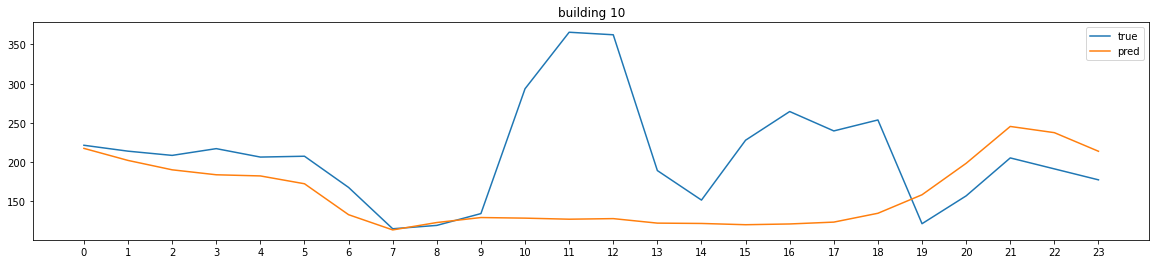

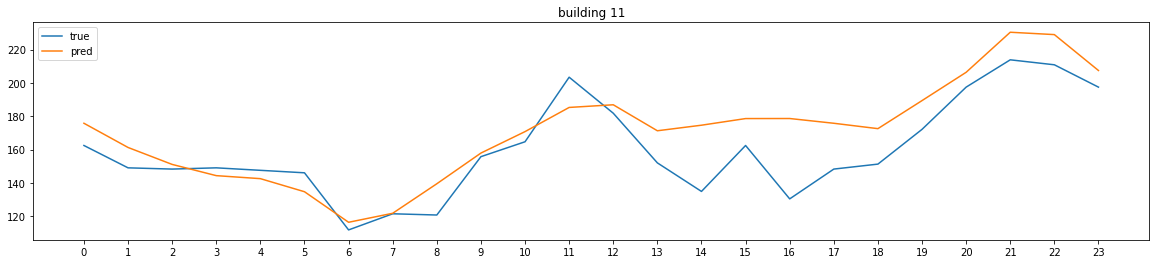

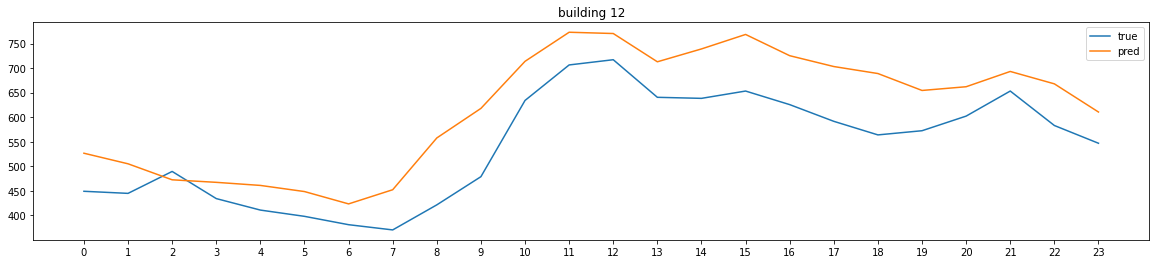

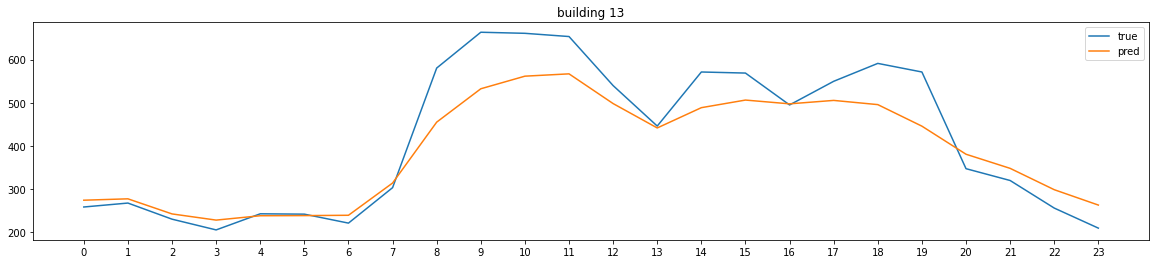

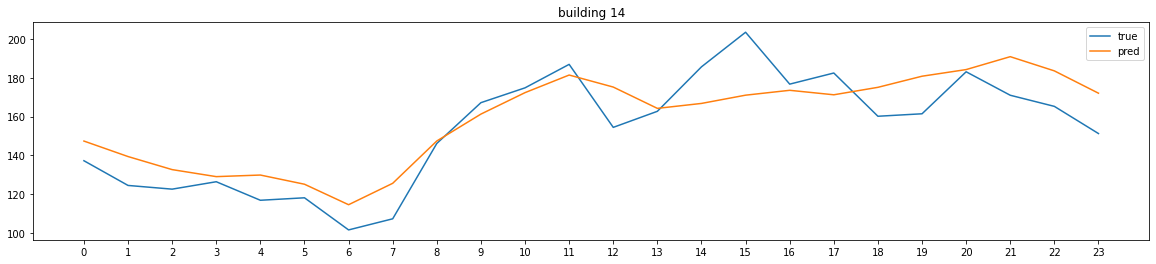

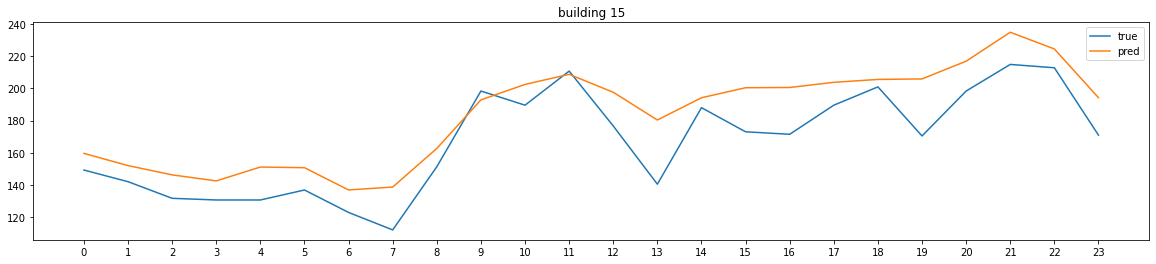

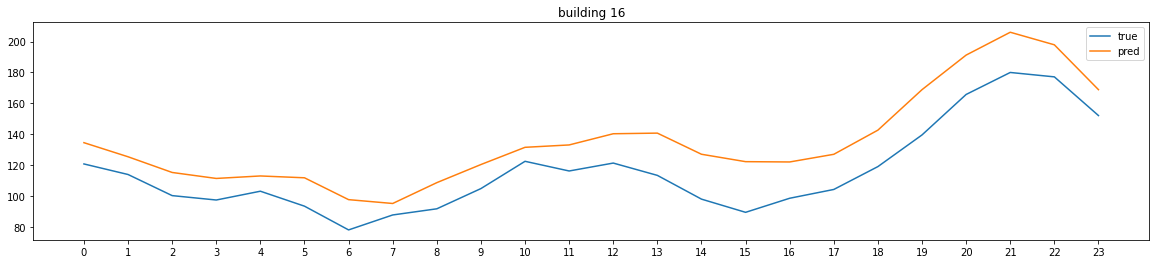

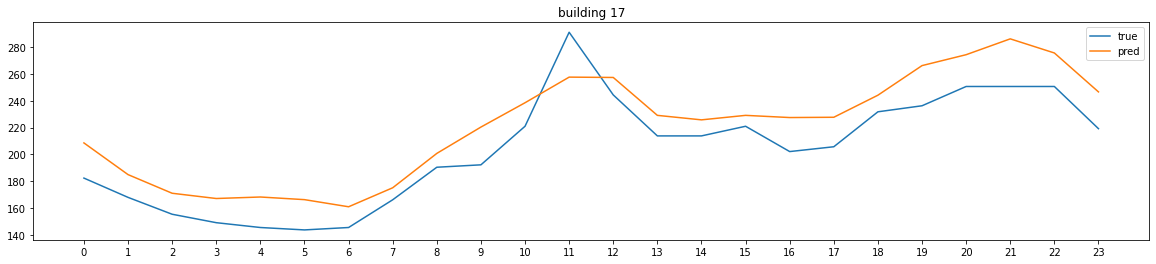

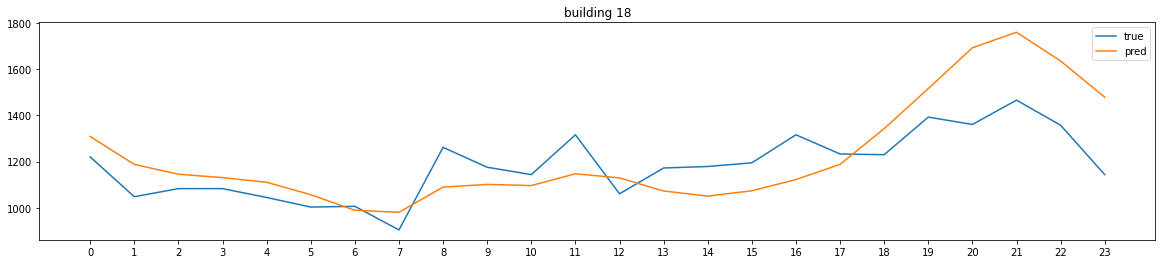

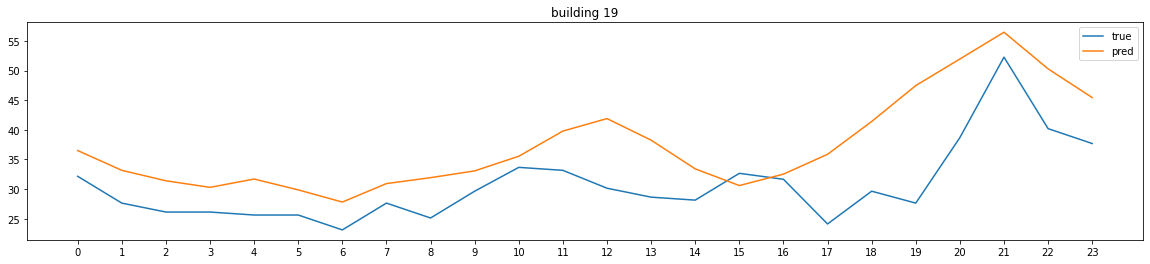

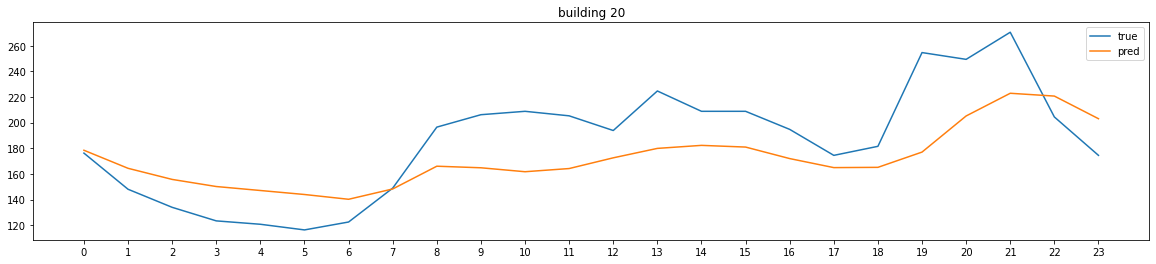

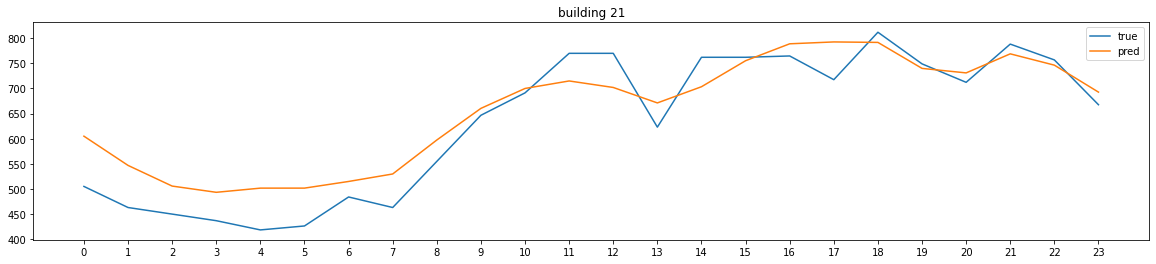

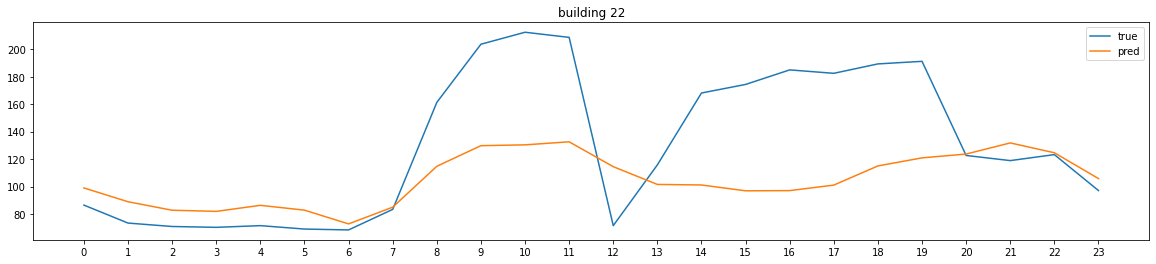

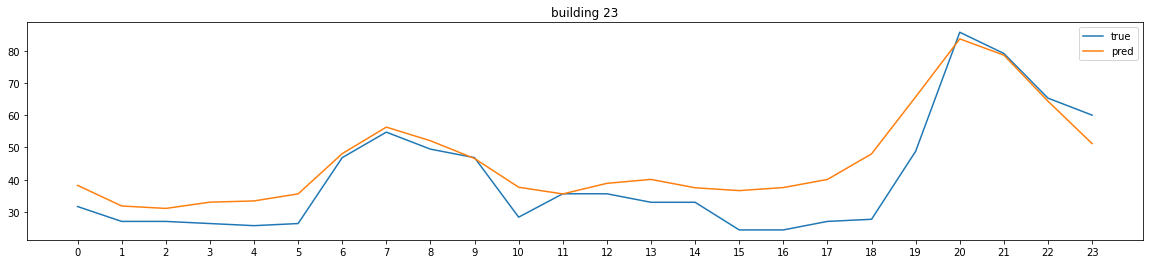

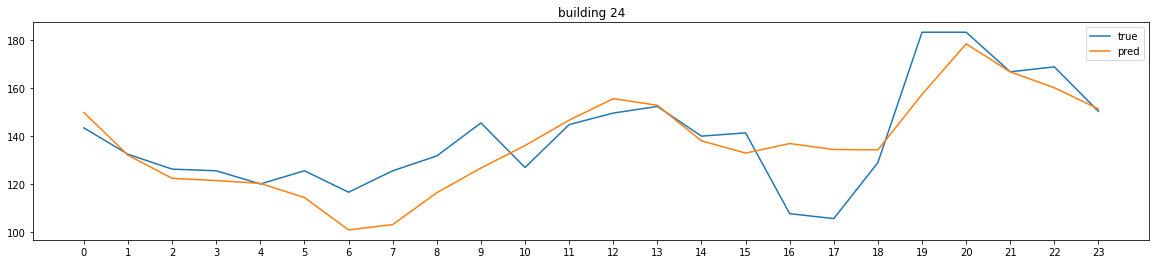

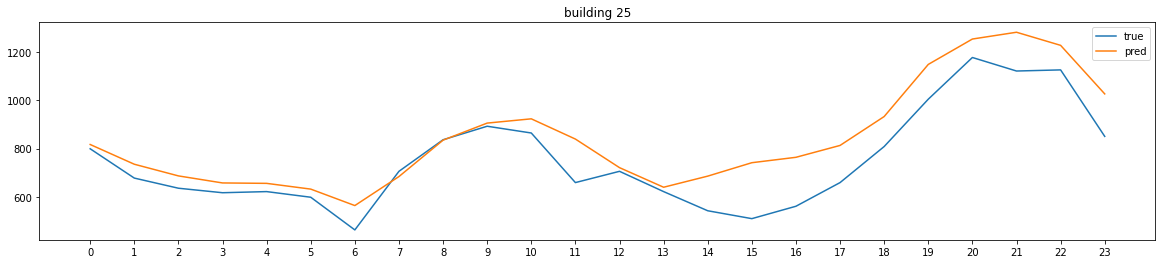

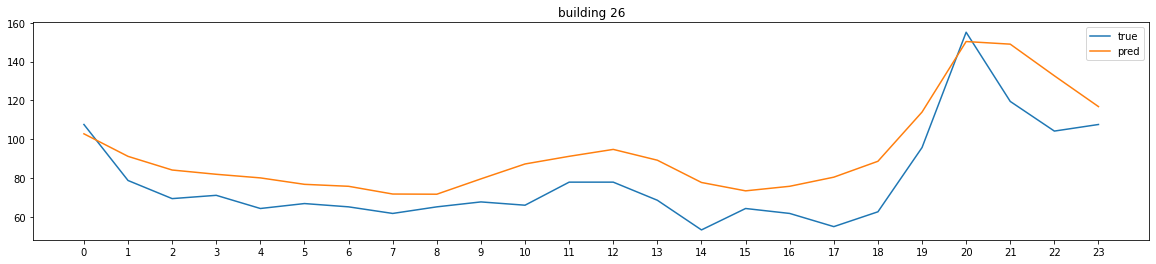

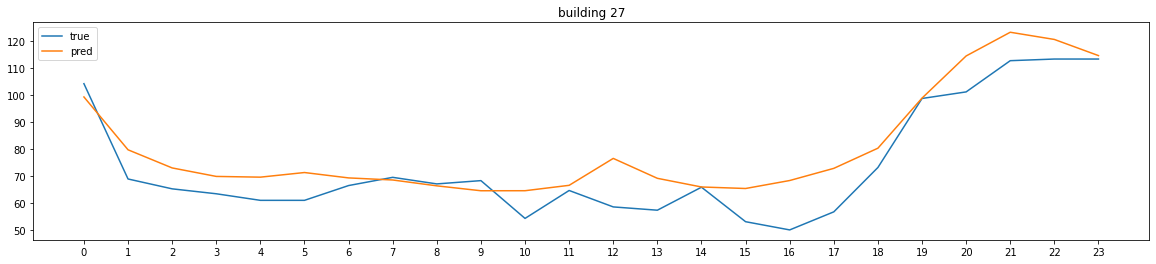

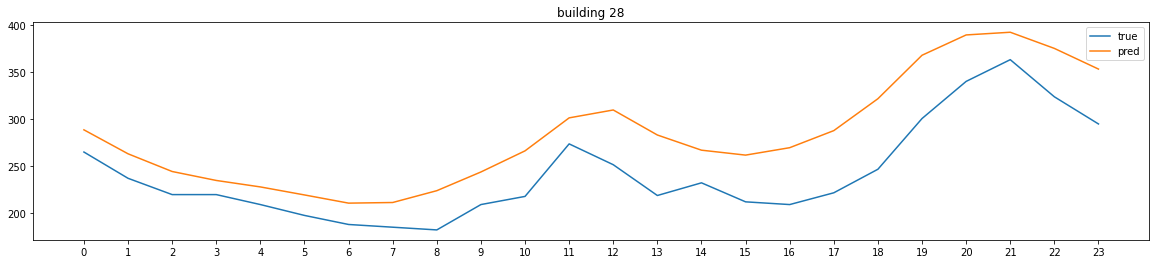

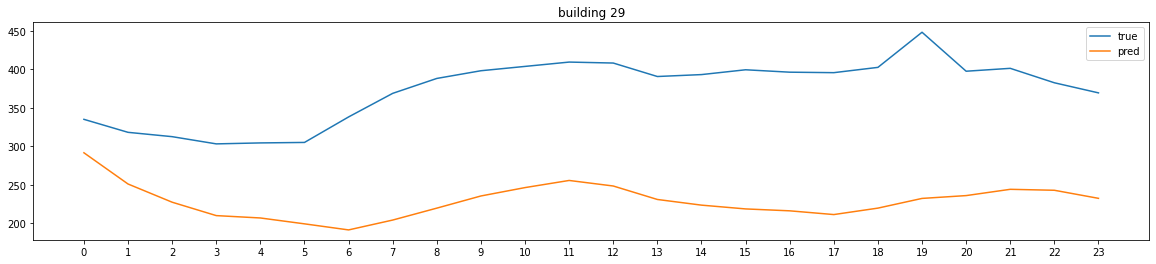

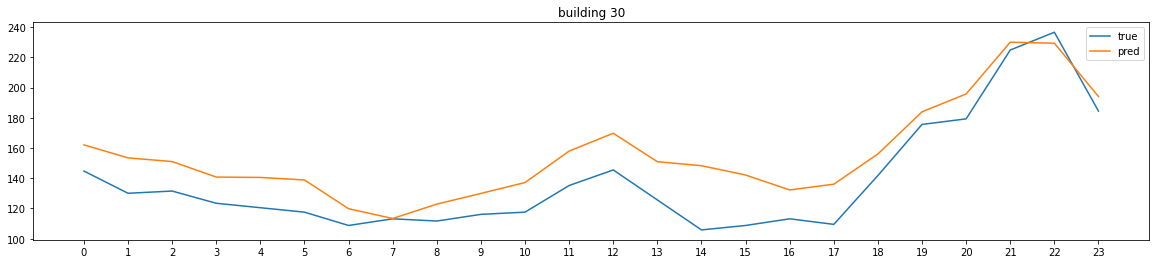

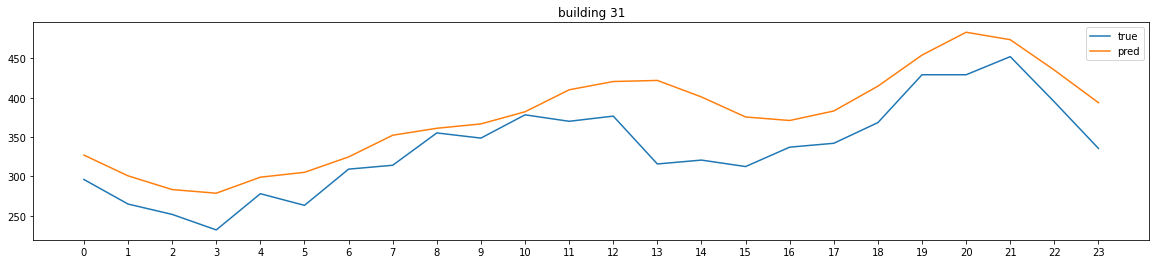

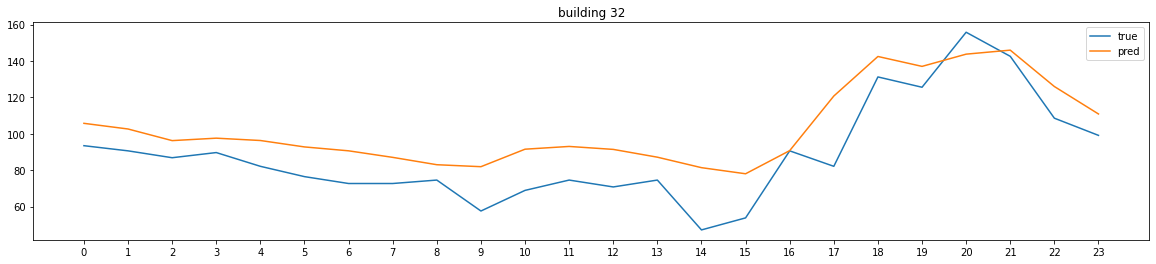

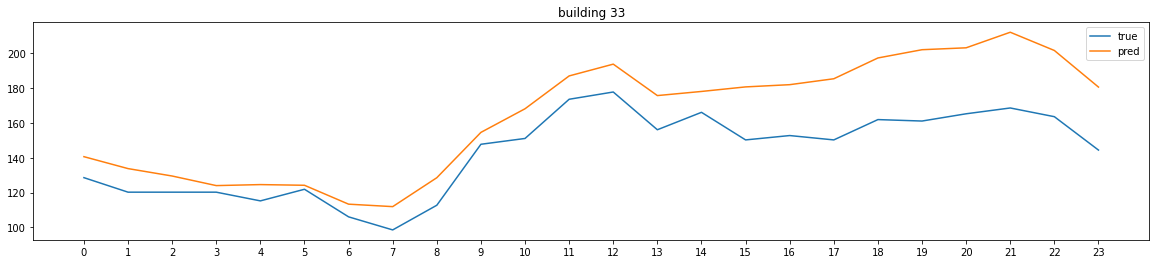

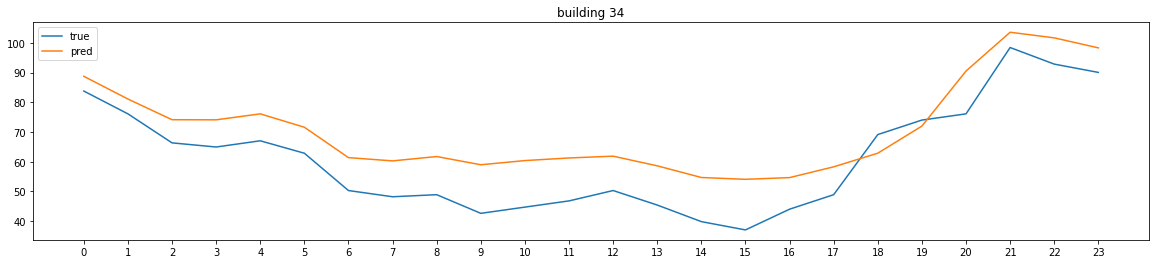

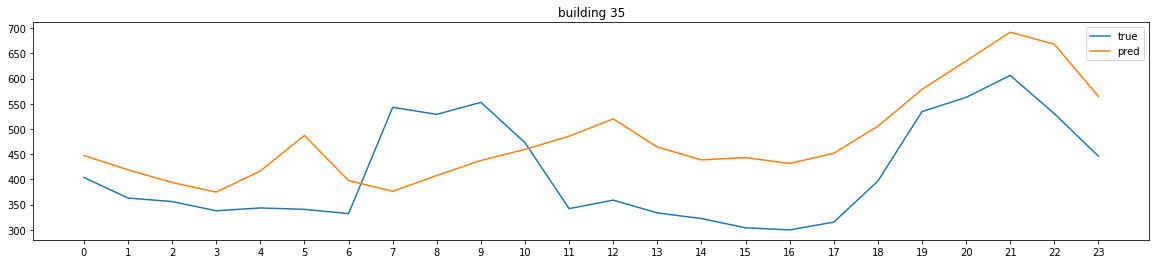

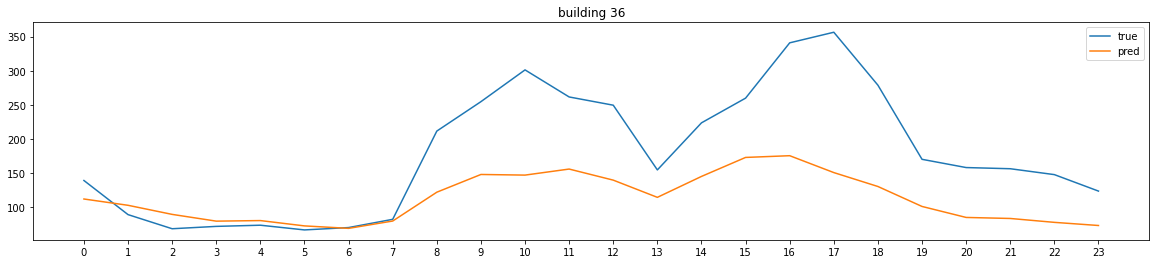

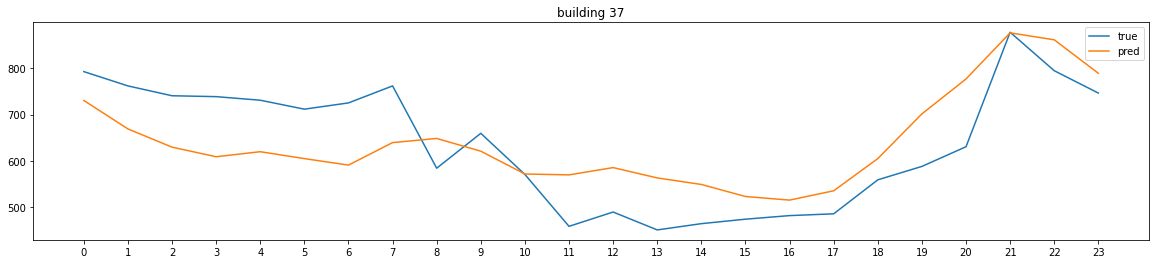

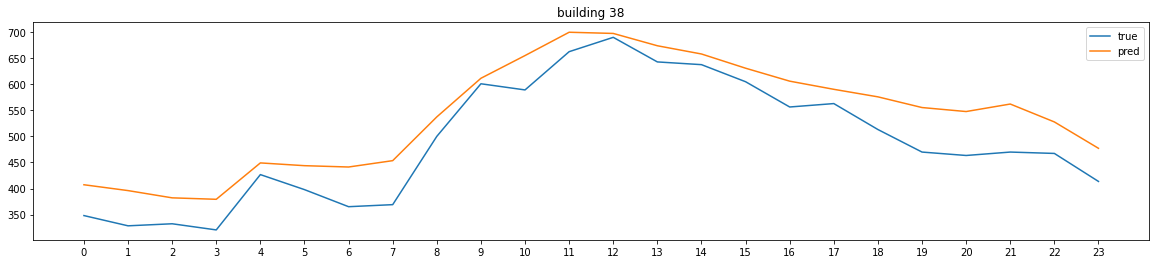

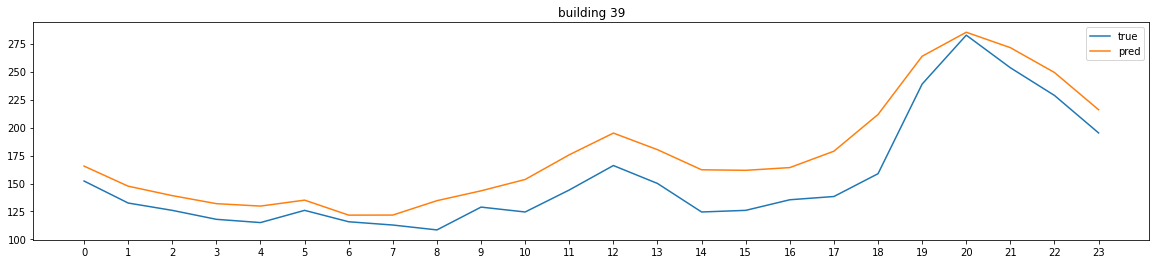

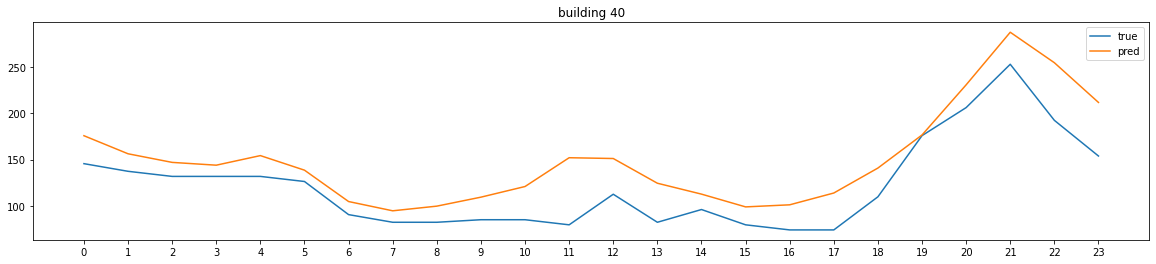

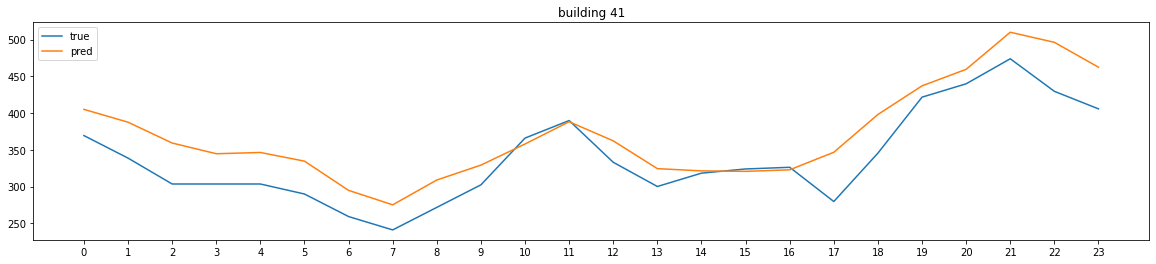

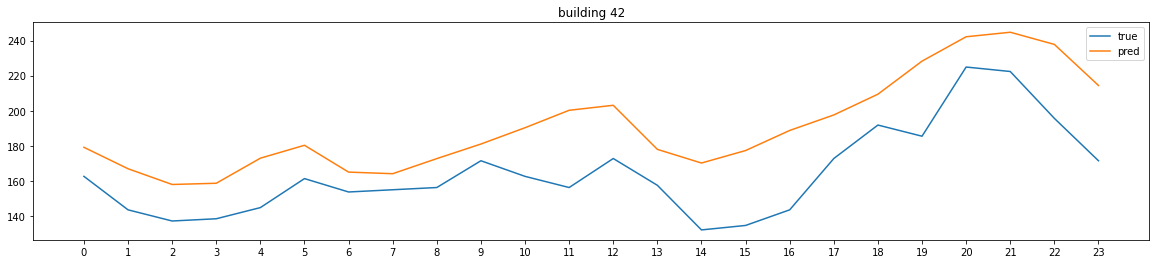

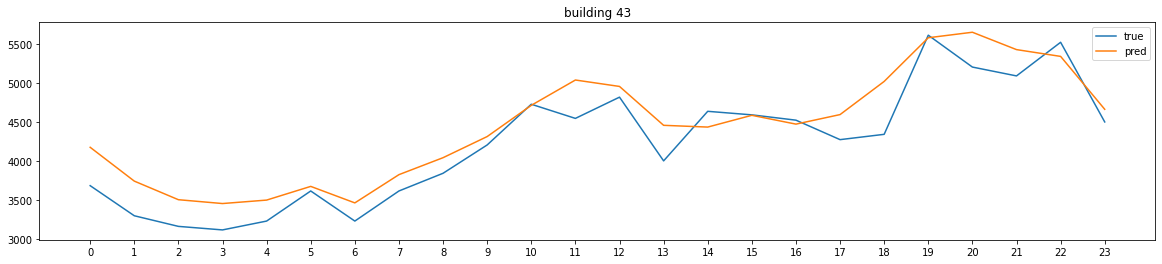

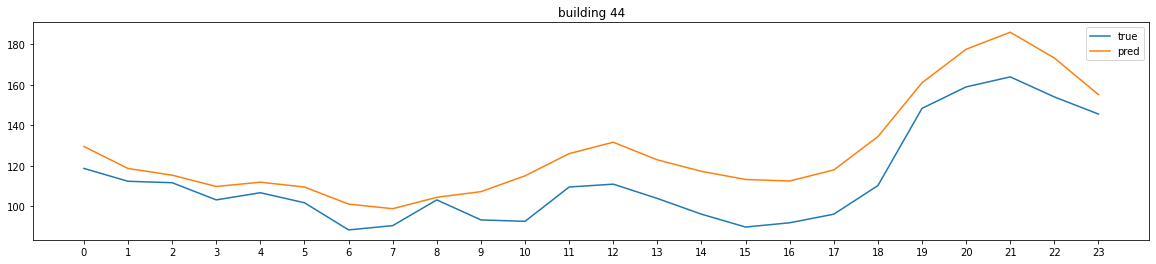

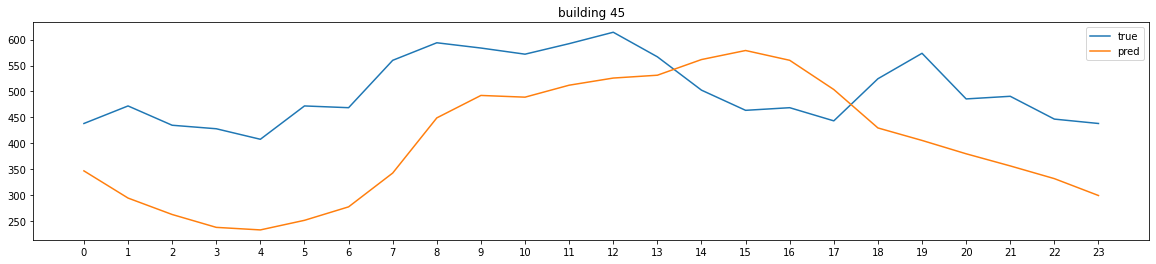

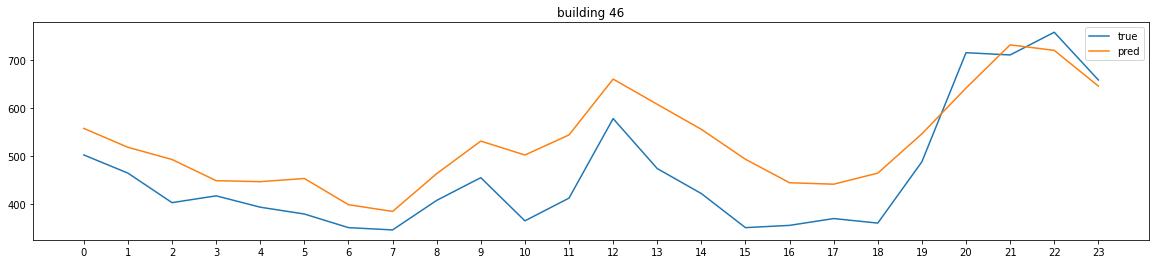

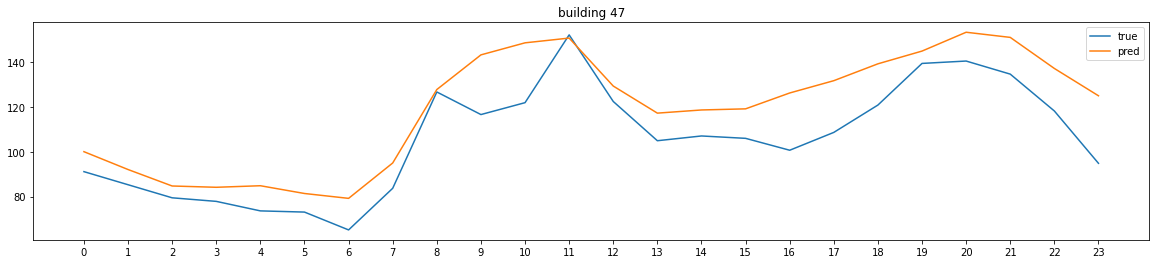

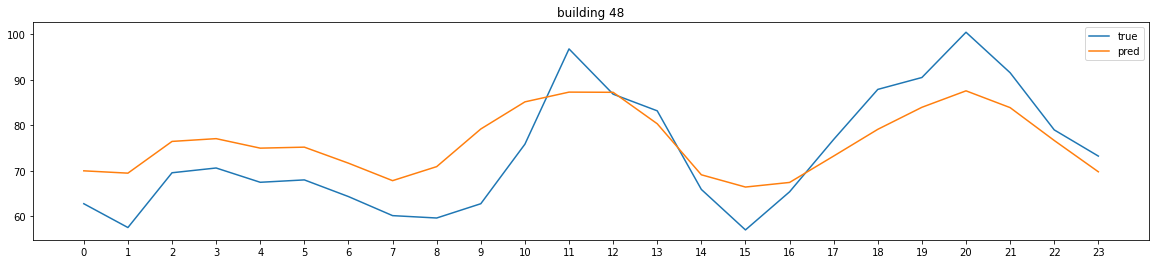

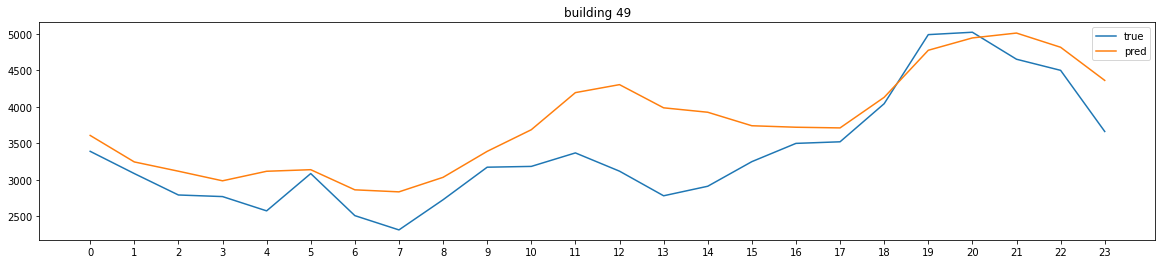

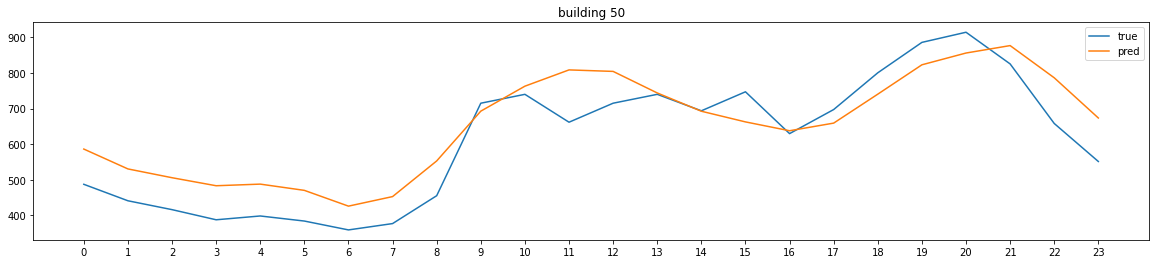

In [16]:
test_true = np.array(data.iloc[:, configs['test_start_index']:data.shape[1]])

for building_idx in range(configs['unique_building_index']):
    plt.figure(figsize=(20, 4))
    plt.plot(test_true[building_idx, :])
    plt.plot(test_pred[building_idx, :])
    plt.title(f'building {building_idx+1}')
    plt.xticks(range(24))
    plt.legend(['true', 'pred'])
    
plt.show()